<a href="https://colab.research.google.com/github/Nikita-Gz/ArGen2/blob/main/ArGen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install ffmpeg-python

In [12]:
import numpy as np
from typing import Any, Callable

In [13]:
def create_plane(resolution: tuple[int, int], scale: float) -> np.array:
    x = resolution[0]
    y = resolution[1]
    smallest_side = min(x, y)

    # the coordinate values are scaled so that the smallest axist matches the scale
    x_range = np.linspace(-scale, scale, x) * x / smallest_side
    y_range = -np.linspace(-scale, scale, y) * y / smallest_side

    x_grid, y_grid = np.meshgrid(x_range, y_range)
    coordinate_plane = np.dstack((x_grid, y_grid))
    return coordinate_plane

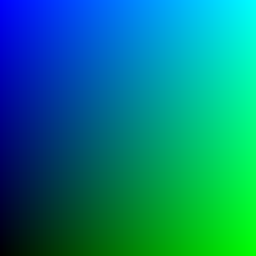

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

def matrix_to_image(matrix, min_val=-1, max_val=1, resolution=(256, 256)) -> Image:
    normalized_matrix = np.clip(matrix, min_val, max_val)
    normalized_matrix = (normalized_matrix - min_val) / (max_val - min_val)

    # Convert to image to BW if it has 1 axis only, or BG and BR if 2 axises,
    # or full RGB if 3 axises
    color_matrix = np.zeros((*matrix.shape[:2], 3))
    match matrix.shape[2]:
        case 1:
            color_matrix[:, :, 0] = normalized_matrix[:, :, 0]  # R
            color_matrix[:, :, 1] = normalized_matrix[:, :, 0]  # G
            color_matrix[:, :, 2] = normalized_matrix[:, :, 0]  # B
        case 2:
            color_matrix[:, :, 0] = 0  # R
            color_matrix[:, :, 1] = normalized_matrix[:, :, 0]  # G
            color_matrix[:, :, 2] = normalized_matrix[:, :, 1]  # B
        case 3:
            color_matrix = normalized_matrix
        case _:
            raise ValueError(f"Invalid matrix shape: {normalized_matrix.shape}")

    gradient_uint8 = (color_matrix * 255).astype(np.uint8)

    img = Image.fromarray(gradient_uint8)
    return img


plane = create_plane((256, 256), 1)
matrix_to_image(plane)

# Effects matrices

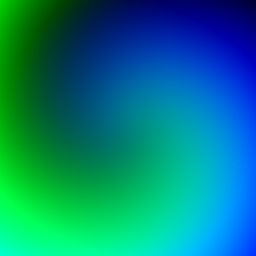

In [15]:
def rotate_around_center(coordinate_plane, center=(0, 0), scale:float=1, phase:float=0) -> np.array:
    # Extract x and y coordinates from the coordinate plane
    x_coords, y_coords = coordinate_plane[:, :, 0], coordinate_plane[:, :, 1]

    # Calculate the distance from each point to the center
    distance_to_center = np.sqrt((x_coords - center[0])**2 + (y_coords - center[1])**2)

    # Calculate angle of rotation for each point relative to the center
    angle = np.arctan2(y_coords - center[1], x_coords - center[0])

    # Apply rotation based on distance from center
    rotated_x = center[0] + (x_coords - center[0]) * np.cos(scale * distance_to_center + phase) - (y_coords - center[1]) * np.sin(scale * distance_to_center + phase)
    rotated_y = center[1] + (x_coords - center[0]) * np.sin(scale * distance_to_center + phase) + (y_coords - center[1]) * np.cos(scale * distance_to_center + phase)

    return np.dstack((rotated_x, rotated_y))

matrix_to_image(rotate_around_center(create_plane((256, 256), 1), scale=2))

<ipython-input-16-02f5fcf0e3be>:16: RuntimeWarning: invalid value encountered in divide
  coordinate_plane_unit_vectors = coordinate_plane / np.linalg.norm(coordinate_plane, axis=-1, keepdims=True)


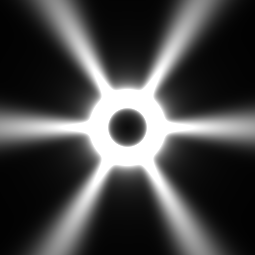

In [16]:
def generate_asterisk_pattern(
        coordinate_plane,
        center=(0, 0),
        num_rays=8,
        ray_width=0.1,
        ray_falloff=0.5,
        center_width=0.2,
        center_outer_ring_falloff=100,
        center_inner_ring_falloff=500):
    """Creates an effect i am experimenting on currently, which resemples the "*"
    sign, with rays stratching from the centre. Except the centre is actually
    a ring"""
    initial_distances = np.linalg.norm(coordinate_plane - center, axis=-1, keepdims=True)

    # "stretches" the coordinate plane to create a ring around the centre, filling it with NaN instead
    coordinate_plane_unit_vectors = coordinate_plane / np.linalg.norm(coordinate_plane, axis=-1, keepdims=True)
    coordinate_plane = np.where(
        initial_distances < center_width,
        np.nan,
        coordinate_plane - coordinate_plane_unit_vectors * center_width)
    x_coords, y_coords = coordinate_plane[:, :, 0], coordinate_plane[:, :, 1]
    altered_distance_to_center = np.linalg.norm(coordinate_plane - center, axis=-1)

    asterisk_pattern = np.zeros_like(altered_distance_to_center)
    angle = np.arctan2(y_coords - center[1], x_coords - center[0])

    # Creates rays based on angle
    for i in range(num_rays):
        ray_angle = i * 2 * np.pi / num_rays
        angle_diff = np.abs(angle - ray_angle)

        # Ensures the angle difference is between 0 and pi
        angle_diff = np.minimum(angle_diff, 2*np.pi - angle_diff)

        # Applies intensity based on angle difference
        asterisk_pattern += np.exp(-angle_diff**2 / (2 * ray_width**2)) / (1 + (altered_distance_to_center**2) * ray_falloff)

    # fills the outer part of the central ring
    center_outer_ring = (1 / altered_distance_to_center**2) / center_outer_ring_falloff
    asterisk_pattern += center_outer_ring

    # fills the inner part of the central ring
    center_inner_ring = np.where(
        initial_distances[:, :, 0] < center_width,
        (1 / (center_width - initial_distances[:, :, 0])**2) / (center_inner_ring_falloff),
        0)
    asterisk_pattern[np.isnan(altered_distance_to_center)] = 0
    asterisk_pattern += center_inner_ring

    return np.expand_dims(asterisk_pattern, axis=-1)

plane = create_plane((255, 255), 1)
astr = generate_asterisk_pattern(plane, num_rays=6, center_width=0.2, ray_falloff=1)
matrix_to_image(astr, 0, 1)

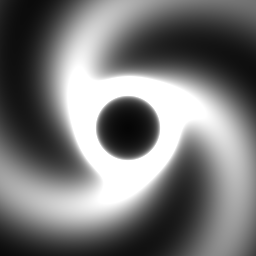

In [17]:
matrix_to_image(
    generate_asterisk_pattern(
        rotate_around_center(
            create_plane((256, 256), 1),
            scale=1.8,
            phase=np.pi / 4),
        num_rays=3,
        ray_width=0.4,
        ray_falloff=1,
        center_width=0.3),
    min_val=0)

# Video generation code

In [18]:
from dataclasses import dataclass


@dataclass
class Keyframe:
    time: float
    value: Any
    interpolation: Callable | None = None


def linear_interpolation(start_keyframe: Keyframe, end_keyframe: Keyframe, time: float) -> float:
    delta_t = end_keyframe.time - start_keyframe.time
    if delta_t == 0:
        return start_keyframe.value

    keyframe_progress = (time - start_keyframe.time) / delta_t
    return start_keyframe.value * (1 - keyframe_progress) + end_keyframe.value * keyframe_progress


class AnimationParameter:
    """Represents parameters in the animation, allowing for interpolation
    between the keyframes as time goes on. If the interpolation function is not
    provided for the keyframe, does linear interpolation by default"""
    def __init__(
            self,
            keyframes: list[Keyframe],
            default_interpolation: Callable = linear_interpolation):
        self._keyframes = sorted(keyframes, key=lambda kf: kf.time)
        self.default_interpolation = default_interpolation


    def __call__(self, time: float) -> Any:
        if len(self._keyframes) == 1:
            return self._keyframes[0].value

        # Finds the keyframes surrounding the given time, assumes they're sorted
        # Todo: maybe implement it without loop, as a challenge?
        prev_keyframe = None
        next_keyframe = None
        for keyframe in self._keyframes:
            if keyframe.time <= time:
                prev_keyframe = keyframe
            if keyframe.time >= time:
                next_keyframe = keyframe
            if prev_keyframe is not None and next_keyframe is not None:
                break
        if prev_keyframe is None:
            return self._keyframes[0].value
        if next_keyframe is None:
            return self._keyframes[-1].value

        interpolation_func = prev_keyframe.interpolation or self.default_interpolation
        return interpolation_func(prev_keyframe, next_keyframe, time)

In [19]:
import ffmpeg

def get_video_writer(resolution: tuple[int, int], fps: int, crf=15):
    writer = (
        ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(resolution[0], resolution[1]), r=fps)
            .output('animation.mp4', pix_fmt='yuv420p', crf=crf, vcodec='h264')
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    return writer

Creating frame 1 out of 600


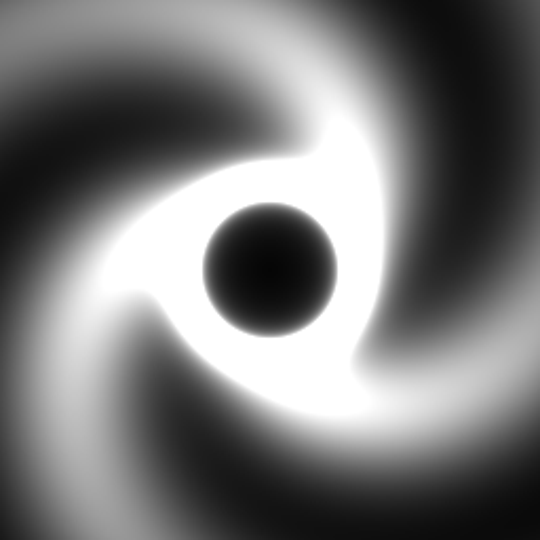

Created frame 1 out of 600
Creating frame 2 out of 600
Created frame 2 out of 600
Creating frame 3 out of 600
Created frame 3 out of 600
Creating frame 4 out of 600
Created frame 4 out of 600
Creating frame 5 out of 600
Created frame 5 out of 600
Creating frame 6 out of 600
Created frame 6 out of 600
Creating frame 7 out of 600
Created frame 7 out of 600
Creating frame 8 out of 600
Created frame 8 out of 600
Creating frame 9 out of 600
Created frame 9 out of 600
Creating frame 10 out of 600
Created frame 10 out of 600
Creating frame 11 out of 600
Created frame 11 out of 600
Creating frame 12 out of 600
Created frame 12 out of 600
Creating frame 13 out of 600
Created frame 13 out of 600
Creating frame 14 out of 600
Created frame 14 out of 600
Creating frame 15 out of 600
Created frame 15 out of 600
Creating frame 16 out of 600
Created frame 16 out of 600
Creating frame 17 out of 600
Created frame 17 out of 600
Creating frame 18 out of 600
Created frame 18 out of 600
Creating frame 19 ou

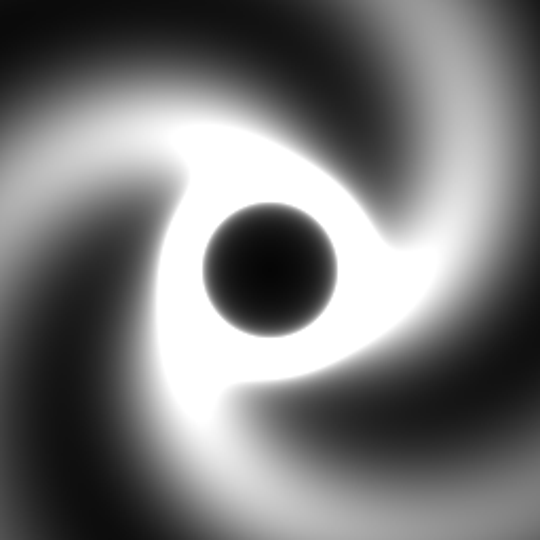

Created frame 101 out of 600
Creating frame 102 out of 600
Created frame 102 out of 600
Creating frame 103 out of 600
Created frame 103 out of 600
Creating frame 104 out of 600
Created frame 104 out of 600
Creating frame 105 out of 600
Created frame 105 out of 600
Creating frame 106 out of 600
Created frame 106 out of 600
Creating frame 107 out of 600
Created frame 107 out of 600
Creating frame 108 out of 600
Created frame 108 out of 600
Creating frame 109 out of 600
Created frame 109 out of 600
Creating frame 110 out of 600
Created frame 110 out of 600
Creating frame 111 out of 600
Created frame 111 out of 600
Creating frame 112 out of 600
Created frame 112 out of 600
Creating frame 113 out of 600
Created frame 113 out of 600
Creating frame 114 out of 600
Created frame 114 out of 600
Creating frame 115 out of 600
Created frame 115 out of 600
Creating frame 116 out of 600
Created frame 116 out of 600
Creating frame 117 out of 600
Created frame 117 out of 600
Creating frame 118 out of 6

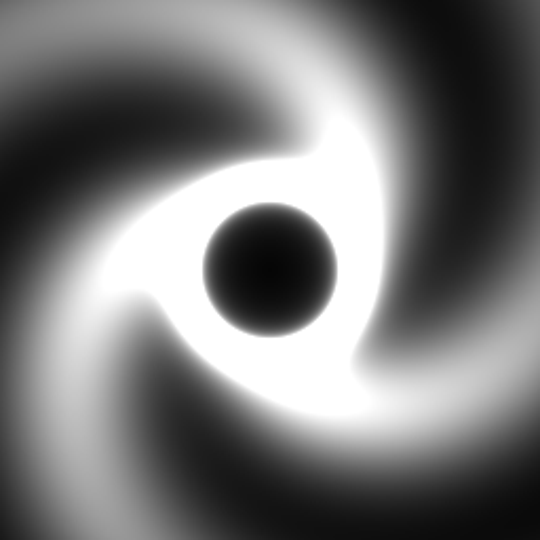

Created frame 201 out of 600
Creating frame 202 out of 600
Created frame 202 out of 600
Creating frame 203 out of 600
Created frame 203 out of 600
Creating frame 204 out of 600
Created frame 204 out of 600
Creating frame 205 out of 600
Created frame 205 out of 600
Creating frame 206 out of 600
Created frame 206 out of 600
Creating frame 207 out of 600
Created frame 207 out of 600
Creating frame 208 out of 600
Created frame 208 out of 600
Creating frame 209 out of 600
Created frame 209 out of 600
Creating frame 210 out of 600
Created frame 210 out of 600
Creating frame 211 out of 600
Created frame 211 out of 600
Creating frame 212 out of 600
Created frame 212 out of 600
Creating frame 213 out of 600
Created frame 213 out of 600
Creating frame 214 out of 600
Created frame 214 out of 600
Creating frame 215 out of 600
Created frame 215 out of 600
Creating frame 216 out of 600
Created frame 216 out of 600
Creating frame 217 out of 600
Created frame 217 out of 600
Creating frame 218 out of 6

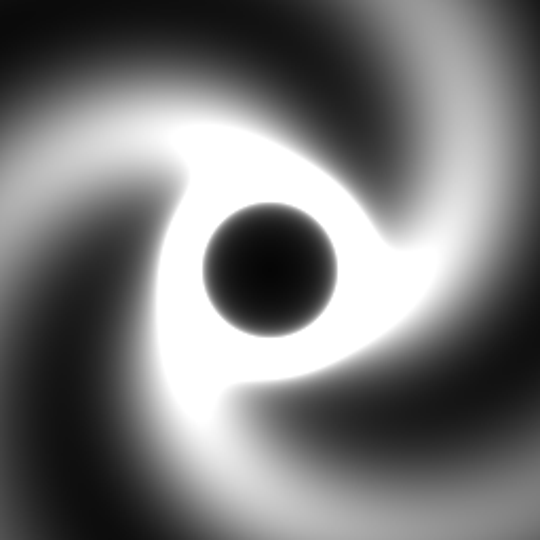

Created frame 301 out of 600
Creating frame 302 out of 600
Created frame 302 out of 600
Creating frame 303 out of 600
Created frame 303 out of 600
Creating frame 304 out of 600
Created frame 304 out of 600
Creating frame 305 out of 600
Created frame 305 out of 600
Creating frame 306 out of 600
Created frame 306 out of 600
Creating frame 307 out of 600
Created frame 307 out of 600
Creating frame 308 out of 600
Created frame 308 out of 600
Creating frame 309 out of 600
Created frame 309 out of 600
Creating frame 310 out of 600
Created frame 310 out of 600
Creating frame 311 out of 600
Created frame 311 out of 600
Creating frame 312 out of 600
Created frame 312 out of 600
Creating frame 313 out of 600
Created frame 313 out of 600
Creating frame 314 out of 600
Created frame 314 out of 600
Creating frame 315 out of 600
Created frame 315 out of 600
Creating frame 316 out of 600
Created frame 316 out of 600
Creating frame 317 out of 600
Created frame 317 out of 600
Creating frame 318 out of 6

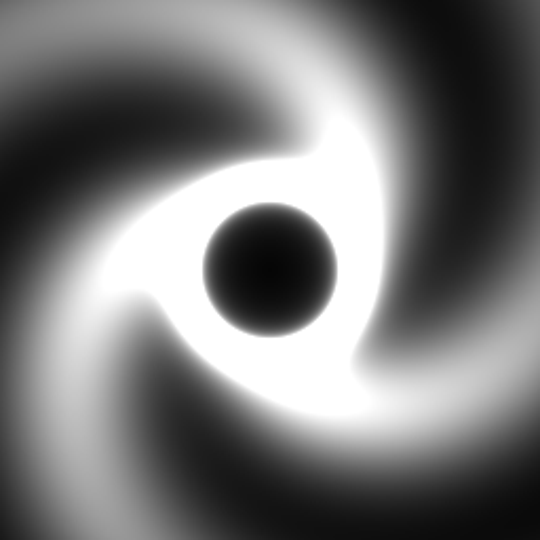

Created frame 401 out of 600
Creating frame 402 out of 600
Created frame 402 out of 600
Creating frame 403 out of 600
Created frame 403 out of 600
Creating frame 404 out of 600
Created frame 404 out of 600
Creating frame 405 out of 600
Created frame 405 out of 600
Creating frame 406 out of 600
Created frame 406 out of 600
Creating frame 407 out of 600
Created frame 407 out of 600
Creating frame 408 out of 600
Created frame 408 out of 600
Creating frame 409 out of 600
Created frame 409 out of 600
Creating frame 410 out of 600
Created frame 410 out of 600
Creating frame 411 out of 600
Created frame 411 out of 600
Creating frame 412 out of 600
Created frame 412 out of 600
Creating frame 413 out of 600
Created frame 413 out of 600
Creating frame 414 out of 600
Created frame 414 out of 600
Creating frame 415 out of 600
Created frame 415 out of 600
Creating frame 416 out of 600
Created frame 416 out of 600
Creating frame 417 out of 600
Created frame 417 out of 600
Creating frame 418 out of 6

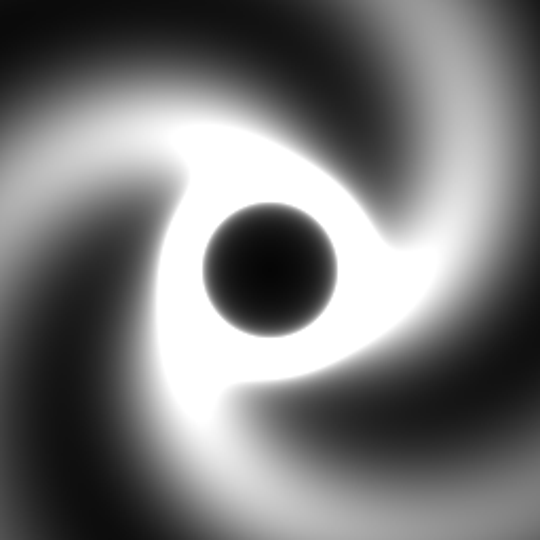

Created frame 501 out of 600
Creating frame 502 out of 600
Created frame 502 out of 600
Creating frame 503 out of 600
Created frame 503 out of 600
Creating frame 504 out of 600
Created frame 504 out of 600
Creating frame 505 out of 600
Created frame 505 out of 600
Creating frame 506 out of 600
Created frame 506 out of 600
Creating frame 507 out of 600
Created frame 507 out of 600
Creating frame 508 out of 600
Created frame 508 out of 600
Creating frame 509 out of 600
Created frame 509 out of 600
Creating frame 510 out of 600
Created frame 510 out of 600
Creating frame 511 out of 600
Created frame 511 out of 600
Creating frame 512 out of 600
Created frame 512 out of 600
Creating frame 513 out of 600
Created frame 513 out of 600
Creating frame 514 out of 600
Created frame 514 out of 600
Creating frame 515 out of 600
Created frame 515 out of 600
Creating frame 516 out of 600
Created frame 516 out of 600
Creating frame 517 out of 600
Created frame 517 out of 600
Creating frame 518 out of 6

0

In [20]:
frames_in_video = 600
fps = 60
video_generation_resolution = (2160, 2160)
video_target_resolution = (video_generation_resolution[0] // 2, video_generation_resolution[1] // 2)
video_preview_resolution = (video_generation_resolution[0] // 4, video_generation_resolution[1] // 4)
coordinate_scale = 1
show_preview_every_n_frames = 100

rotation_phase = AnimationParameter([Keyframe(0, 0), Keyframe(1, np.pi*2)])

video_writer = get_video_writer(video_target_resolution, fps=fps)
for frame_i in range(frames_in_video):
    print(f'Creating frame {frame_i+1} out of {frames_in_video}')
    progress = frame_i / frames_in_video

    generated_frame = matrix_to_image(
        generate_asterisk_pattern(
            rotate_around_center(
                create_plane((256, 256), 1),
                scale=-1.8,
                phase=rotation_phase(progress)),
            num_rays=3,
            ray_width=0.4,
            ray_falloff=1,
            center_width=0.3),
        min_val=0)

    target_frame = generated_frame.resize(video_target_resolution, resample=Image.BICUBIC)

    if frame_i % show_preview_every_n_frames == 0:
        preview_frame = generated_frame.resize(video_preview_resolution, resample=Image.BICUBIC)
        display(preview_frame)

    video_writer.stdin.write(np.asarray(target_frame).astype('uint8').tobytes())
    print(f'Created frame {frame_i+1} out of {frames_in_video}')
video_writer.stdin.close()
video_writer.wait()